# Optimization Model - Bus Charging Scheduling | Sensitivity Analysis

## Initialization

In [17]:
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import logging
logging.getLogger('pyomo.core').setLevel(logging.ERROR)

In [18]:
data = pd.read_excel('../Instances/input_small.xlsx', None)
EXEC_PATH = '/Applications/CPLEX_Studio221/cplex/bin/x86-64_osx/cplex'
#EXEC_PATH = '/home/jonatas.manzolli/Documents/opt/ibm/CPLEX_Studio201/cplex/bin/x86-64_linux/cplex'

## Model definition

In [19]:
def createModel(data, C_bat = data['Buses']['Bus (kWh)'].tolist(), k= len(data['Buses']['Bus (kWh)']), alpha = data['Chargers']['Charger (kWh/min)'].tolist(),
n = len(data['Chargers']['Charger (kWh/min)']),R = 130):

    model = pyo.ConcreteModel() # create model
    
    # data
    i = len(data['Trip time']['Time begin (min)'])
    t = len(data['Energy price']['Energy buying price (per minute)'])
    l = len(data['Power price']['Power'])
    T_start = data['Trip time']['Time begin (min)'].tolist()
    T_start = [int(x) for x in T_start]
    T_end = data['Trip time']['Time finish (min)'].tolist()
    T_end = [int(x) for x in T_end]
    ch_eff = 0.90
    dch_eff = 1/0.9
    gama = data['Energy consumption']['Uncertain energy (kWh/km*min)'].tolist()
    P = data['Energy price']['Energy buying price (per minute)'].tolist()
    S = data['Energy price']['Energy selling price (per minute)'].tolist()
    E_0 = 0.2
    E_min = 0.2
    E_max = 1
    E_end = 0.2
    d_off = 20
    d_on = 40
    U_pow = data['Power price']['Power'].tolist()
    U_price = data['Power price']['Price'].tolist()
    U_max = data['Chargers']['Max Power (kW)'].tolist()
    Ah = 905452
    V = 512
    T = t

    # sets
    model.I = pyo.RangeSet(i) # set of trips
    model.T = pyo.RangeSet(t) # set of timesteps
    model.K = pyo.RangeSet(k) # set of buses
    model.N = pyo.RangeSet(n) # set of chargers
    model.L = pyo.RangeSet(l) # set of peak power levels

    # parameters
    model.T_start = pyo.Param(model.I, initialize=lambda model, i: T_start[i-1]) # start time of trip i
    model.T_end = pyo.Param(model.I, initialize=lambda model, i: T_end[i-1]) # end time of trip i
    model.alpha = pyo.Param(model.N, initialize=lambda model, n: alpha[n-1]) # charging power of charger n
    model.beta = pyo.Param(model.N, initialize=lambda model, n: alpha[n-1]) # discharging power of charger n
    model.ch_eff = pyo.Param(initialize=ch_eff) # charging efficiency of charger n
    model.dch_eff = pyo.Param(initialize=dch_eff) # discharging efficiency of charger n
    model.P = pyo.Param(model.T, initialize=lambda model, t: P[t-1]) # electricity purchasing price in time t
    model.S = pyo.Param(model.T, initialize=lambda model, t: S[t-1]) # electricity selling price in time t
    model.gama = pyo.Param(model.I, initialize=lambda model, i: gama[i-1],mutable=True) # energy consumption
    model.E_0 = pyo.Param(initialize=E_0) # initial energy level of bus k
    model.E_min = pyo.Param(initialize=E_min) # minimum energy level allowed for bus k
    model.E_max = pyo.Param(initialize=E_max) # maximum energy level allowed for bus k
    model.E_end = pyo.Param(initialize=E_end) # minimum energy after an operation day for bus k
    model.C_bat = pyo.Param(model.K, initialize=lambda model, k: C_bat[k-1],mutable=True) # total capacity of the bus k battery
    model.U_pow = pyo.Param(model.L, initialize=lambda model, l: U_pow[l-1]) # power level l
    model.U_price = pyo.Param(model.L, initialize=lambda model, l: U_price[l-1]) # purchasing price for power level l
    model.U_max = pyo.Param(initialize=U_max[0]) # contracted power
    model.R = pyo.Param(initialize=R) # battery replacement costs of the bus k
    model.Ah = pyo.Param(initialize=Ah) # energy consumed until EOL of bus k
    model.V = pyo.Param(initialize=V) # operational voltage of charger n

    # binary variables
    model.b = pyo.Var(model.K,model.I, model.T, within=pyo.Binary) # binary variable indicating if bus k is serving trip i at time t
    model.x = pyo.Var(model.K, model.N, model.T, domain=pyo.Binary) # binary variable indicating if bus k is occupying a charger n at time t to charge
    model.y = pyo.Var(model.K, model.N, model.T, domain=pyo.Binary) # binary variable indicating if bus k is occupying a charger n at time t to discharge
    model.c = pyo.Var(model.K, model.T, domain=pyo.Binary)  # binary variable indicating if bus k is charging/discharging at time t
    model.u = pyo.Var(model.L, domain=pyo.Binary)  # binary variable indicating the peak power level l

    # non-negative variables
    model.e = pyo.Var(model.K, model.T, within=pyo.NonNegativeReals) # energy level of bus k at time t
    model.w_buy = pyo.Var(model.T, within=pyo.NonNegativeReals) # electricity purchased from the grid at time t
    model.w_sell = pyo.Var(model.T, within=pyo.NonNegativeReals) # electricity sold to the grid at time t
    model.d = pyo.Var(model.K, model.T, within=pyo.NonNegativeReals) # total degradation cost of the bus k battery at time t

    # constraints
    model.constraints = pyo.ConstraintList()
    #constraint 2
    for k in model.K:
        for t in model.T:
            model.constraints.add(sum(model.b[k,i,t] for i in model.I) + model.c[k,t] <=1)

    #constraint 3
    for i in model.I: 
        for t in range(model.T_start[i],model.T_end[i]):
            model.constraints.add(sum(model.b[k,i,t] for k in model.K) == 1)

    #constraint 4
    for i in model.I:
        for k in model.K:
            for t in range(model.T_start[i],model.T_end[i]-1):
                model.constraints.add(model.b[k,i,t+1] >= model.b[k,i,t])

    #constraint 5
    for n in model.N:
        for t in model.T:
            model.constraints.add(sum(model.x[k,n,t] for k in model.K) + sum(model.y[k,n,t] for k in model.K) <= 1)

    #constraint 6
    for k in model.K:
        for t in model.T:
            model.constraints.add(sum(model.x[k,n,t] for n in model.N) + sum(model.y[k,n,t] for n in model.N) <= model.c[k,t])

    #constraint 7
    for k in model.K:
        for t in range(2,T+1):
            model.constraints.add(model.e[k,t] == model.e[k,t-1] + sum(model.ch_eff*model.alpha[n]*model.x[k,n,t] for n in model.N) - sum(model.gama[i]*model.b[k,i,t] for i in model.I) - sum(model.dch_eff*model.beta[n]*model.y[k,n,t] for n in model.N))

    #constraint 8.1
    for k in model.K:
        for n in model.N:
            for t in range(2,T-d_off):
                model.constraints.add(1 - model.x[k,n,t] + model.x[k,n,t-1]  + ((1/d_off)*sum(model.x[k,n,j] for j in range(t,t+d_off))) <= 2) # 33

    #constraint 8.2
    for k in model.K:
        for n in model.N:
            for t in range(T-d_off+1,T):
                model.constraints.add(1 - model.x[k,n,t] + model.x[k,n,t-1] + ((1/(T-t+1))*sum(model.x[k,n,j] for j in range(t,T))) <= 2) # 35

    #constraint 8.3
    for k in model.K:
        for n in model.N:
            for t in range(2,T-d_on):
                model.constraints.add(1 - model.x[k,n,t] + model.x[k,n,t-1] + ((1/d_on)*sum(model.x[k,n,j] for j in range(t,t+d_on))) >= 1) # 34

    #constraint 8.4
    for k in model.K:
        for n in model.N:
            for t in range(T-d_on+1,T):
                model.constraints.add(1 - model.x[k,n,t] + model.x[k,n,t-1] + ((1/(T-t+1))*sum(model.x[k,n,j] for j in range(t,T))) >= 1) # 36

    #constraint 9.1
    for t in model.T:
        model.constraints.add(sum(model.ch_eff*model.alpha[n]*model.x[k,n,t] for n in model.N for k in model.K) == model.w_buy[t])

    #constraint 9.2
    for t in model.T:
            model.constraints.add(sum(model.dch_eff*model.beta[n]*model.y[k,n,t] for n in model.N for k in model.K) == model.w_sell[t])

    #constraint 10
    model.constraints.add(sum(model.u[l] for l in model.L)==1)

    #constraint 11
    for t in model.T:
        model.constraints.add(sum(model.alpha[n]*model.x[k,n,t] for k in model.K for n in model.N) <= sum(model.U_pow[l]*model.u[l] for l in model.L))
        
    #constraint 12
    for t in model.T:
        model.constraints.add(sum(model.alpha[n]*model.x[k,n,t] for k in model.K for n in model.N) <= model.U_max)

    #constraint 13
    for k in model.K:
        for t in model.T:
            model.constraints.add(model.e[k,t] >= model.C_bat[k] * model.E_min)

    #constrait 14
    for k in model.K:
        for t in model.T:
            model.constraints.add(E_max * model.C_bat[k] >= model.e[k,t] + sum(model.ch_eff*model.alpha[n]*model.x[k,n,t] for n in model.N))          

    #constraint 15.1
    for k in model.K:
        model.constraints.add(model.e[k,1] == model.E_0*model.C_bat[k])

    #constraint 15.2
    for k in model.K:
        model.constraints.add(model.e[k,T-1] + sum(model.ch_eff*model.alpha[n]*model.x[k,n,T] for n in model.N) >= model.E_end*model.C_bat[k])   

    #constraint 16
    for k in model.K:
        for t in model.T:
            model.constraints.add(model.d[k,t] == ((model.R*model.C_bat[1]*1000)/(model.Ah*model.V))* sum(model.beta[n]*model.y[k,n,t] for n in model.N))

    return model

## Solver

In [20]:
# preparing the solver
opt = pyo.SolverFactory('cplex',executable=EXEC_PATH)
opt.options['timelimit'] = 3600
opt.options['mipgap'] = 0.01

## Sensitivity Analysis

In [21]:
def visualizationData (K,T,e,w,d):
    # retriving energy
    bus_list = []
    energy_list = []
    for k in K:
        bus_number = 'bus' + ' ' + str(k)
        bus_list.append(bus_number)
    for t in T:
        for  k in K:
            energy_list.append(pyo.value(e[k,t]))
    energy_array = np.reshape(energy_list, (len(T), len(bus_list)))
    Energy = pd.DataFrame(energy_array,index=T, columns=bus_list)

    #retriving power
    transac_list = []
    for t in T:
        value = pyo.value(w[t])
        transac_list.append(value)
    W = pd.DataFrame(transac_list, index=T, columns=['Power'])

    #retriving degradation
    degradation_list = []
    for k in K:
        for t in T:
            degradation_list.append(pyo.value(d[k,t]))
    degradation = pd.DataFrame(degradation_list)
    return Energy, W, degradation

In [22]:
def numberBuses(num_bus):
    result = []
    axys_x = []
    for i in range(1,num_bus+1):
        try:
            print("===== number of buses is:",i)
            C_bat = data['Buses']['Bus (kWh)'].tolist()
            C_bat = [C_bat[0]] * i
            model = createModel(data,k=i,C_bat=C_bat)
            opt.solve(model, tee=False)
            print("objective function is:", model.obj(),'\n')
            result.append(model.obj())
            axys_x.append('Bus(es) = '+str(i))
            Energy, Power, Degradation = visualizationData(model.K,model.T,model.e,model.w_buy,model.d)
            with pd.ExcelWriter('../Results/output_sensitivity.xlsx',engine="openpyxl", mode='a',if_sheet_exists='new') as writer:
                    Energy.to_excel(writer, sheet_name='energy-numBuses')
                    Power.to_excel(writer, sheet_name='power-numBuses')
                    Degradation.to_excel(writer, sheet_name='degradation-numBuses')
        except ValueError:
            print('\n-----> Infeasible <-----\n')
    df_result = pd.DataFrame(result)
    df_result = df_result.T
    df_result.columns = axys_x
    df_result.index = ['value']
    with pd.ExcelWriter('../Results/output_sensitivity.xlsx',engine="openpyxl", mode='a',if_sheet_exists='new') as writer:
        df_result.to_excel(writer,sheet_name='sensitivity_bus')
    plt.subplots(figsize=(12,6))
    plt.bar(axys_x,result)
    return model, df_result

def batCapacity(bat_begin,bat_end,step):
    result = []
    axys_x = []
    for bat in range(bat_begin,bat_end+step,step):
        try:
            print("===== battery capacity is:",bat)
            C_bat = [bat] * len(data['Buses']['Bus (kWh)'])
            model = createModel(data,C_bat=C_bat)
            opt.solve(model, tee=False)
            print("objective function is:", model.obj(),'\n')
            result.append(model.obj())
            axys_x.append(str(bat)+' kWh')
            Energy, Power, Degradation = visualizationData(model.K,model.T,model.e,model.w_buy,model.d)
            with pd.ExcelWriter('../Results/output_sensitivity.xlsx',engine="openpyxl", mode='a',if_sheet_exists='new') as writer:
                    Energy.to_excel(writer, sheet_name='energy-batCapacity')
                    Power.to_excel(writer, sheet_name='power-batCapacity')
                    Degradation.to_excel(writer, sheet_name='degradation-batCapacity')
        except ValueError:
            print('\n-----> Infeasible <-----\n')
    df_result = pd.DataFrame(result)
    df_result = df_result.T
    df_result.columns = axys_x
    df_result.index = ['value']
    with pd.ExcelWriter('../Results/output_sensitivity.xlsx',engine="openpyxl", mode='a',if_sheet_exists='replace') as writer:
        df_result.to_excel(writer,sheet_name='sensitivity_battery')
    plt.subplots(figsize=(12,6))
    plt.bar(axys_x,result)
    return model, df_result

def numberChargers(num_char):
    result = []
    axys_x = []
    for n in range(1,num_char+1):
        try:
            print("===== number of chargers is:",n)
            alpha = data['Chargers']['Charger (kWh/min)'].tolist()
            alpha = [alpha[0]] * n
            model = createModel(data,n=n,alpha=alpha)
            opt.solve(model, tee=False)
            print("objective function is:", model.obj(),'\n')
            result.append(model.obj())
            axys_x.append('Charger(s) = '+ str(n))
            Energy, Power, Degradation = visualizationData(model.K,model.T,model.e,model.w_buy,model.d)
            with pd.ExcelWriter('../Results/output_sensitivity.xlsx',engine="openpyxl", mode='a',if_sheet_exists='new') as writer:
                    Energy.to_excel(writer, sheet_name='energy-numChargers')
                    Power.to_excel(writer, sheet_name='power-numChargers')
                    Degradation.to_excel(writer, sheet_name='degradation-numChargers')
        except ValueError:
            print('\n-----> Infeasible <-----\n')
    df_result = pd.DataFrame(result)
    df_result = df_result.T
    df_result.columns = axys_x
    df_result.index = ['value']
    with pd.ExcelWriter('../Results/output_sensitivity.xlsx',engine="openpyxl", mode='a',if_sheet_exists='replace') as writer:
        df_result.to_excel(writer,sheet_name='sensitivity_chargers')
    plt.subplots(figsize=(12,6))
    plt.bar(axys_x,result)
    return model, df_result

def charPower(pow_begin,pow_end,step):
    result = []
    axys_x = []
    for pow in np.arange(pow_begin,pow_end+step,step):
        try:
            print("===== charging power is:",pow*60)
            alpha = [pow] * len(data['Chargers']['Charger (kWh/min)'])
            model = createModel(data,alpha=alpha)
            opt.solve(model, tee=False)
            print("objective function is:", model.obj(),'\n')
            result.append(model.obj())
            axys_x.append(str(int(pow*60))+' kW')
            Energy, Power, Degradation = visualizationData(model.K,model.T,model.e,model.w_buy,model.d)
            with pd.ExcelWriter('../Results/output_sensitivity.xlsx',engine="openpyxl", mode='a',if_sheet_exists='new') as writer:
                    Energy.to_excel(writer, sheet_name='energy-charPower')
                    Power.to_excel(writer, sheet_name='power-charPower')
                    Degradation.to_excel(writer, sheet_name='degradation-charPower')            
        except ValueError:
            print('\n-----> Infeasible <-----\n')
    df_result = pd.DataFrame(result)
    df_result = df_result.T
    df_result.columns = axys_x
    df_result.index = ['value']
    with pd.ExcelWriter('../Results/output_sensitivity.xlsx',engine="openpyxl", mode='a',if_sheet_exists='replace') as writer:
        df_result.to_excel(writer,sheet_name='sensitivity_power')
    plt.subplots(figsize=(12,6))
    plt.bar(axys_x,result)
    return model, df_result

In [23]:
def run_sensitivity(num_bus=None,battery=None,num_char=None,power=None):
    model_bus = None
    model_bat = None
    model_char = None
    model_pow = None
    result_bus = None
    result_bat = None
    result_char = None
    result_pow = None
    # creating an empty Excel file
    aux = pd.DataFrame(battery) # creatign the excel output file
    with pd.ExcelWriter('../Results/output_sensitivity.xlsx') as writer:
        aux.to_excel(writer,sheet_name='sensitivity_bus')
    
    if num_bus != None:
        model_bus, result_bus = numberBuses(num_bus)
    if battery != None:    
        model_bat, result_bat = batCapacity(battery[0],battery[1],battery[2])
    if num_char != None:
        model_char, result_char = numberChargers(num_char)
    if power != None:
        model_pow, result_pow = charPower(power[0],power[1],power[2])

    return model_bus, model_bat, model_char, model_pow, result_bus, result_bat, result_char, result_pow

## Results

===== number of buses is: 1
objective function is: 4.1323200000000035 

===== number of buses is: 2
objective function is: 4.1323200000000035 

===== battery capacity is: 100
ERROR: evaluating object as numeric value: w_buy[1]
        (object: <class 'pyomo.core.base.var._GeneralVarData'>)
    No value for uninitialized NumericValue object w_buy[1]

-----> Infeasible <-----

===== battery capacity is: 150
ERROR: evaluating object as numeric value: w_buy[1]
        (object: <class 'pyomo.core.base.var._GeneralVarData'>)
    No value for uninitialized NumericValue object w_buy[1]

-----> Infeasible <-----

===== battery capacity is: 200
objective function is: 4.1323200000000035 

===== number of chargers is: 1
objective function is: 4.1323200000000035 

===== number of chargers is: 2
objective function is: 4.1323200000000035 

===== number of chargers is: 3
objective function is: 4.1323200000000035 

===== number of chargers is: 4
objective function is: 4.1323200000000035 

===== number 

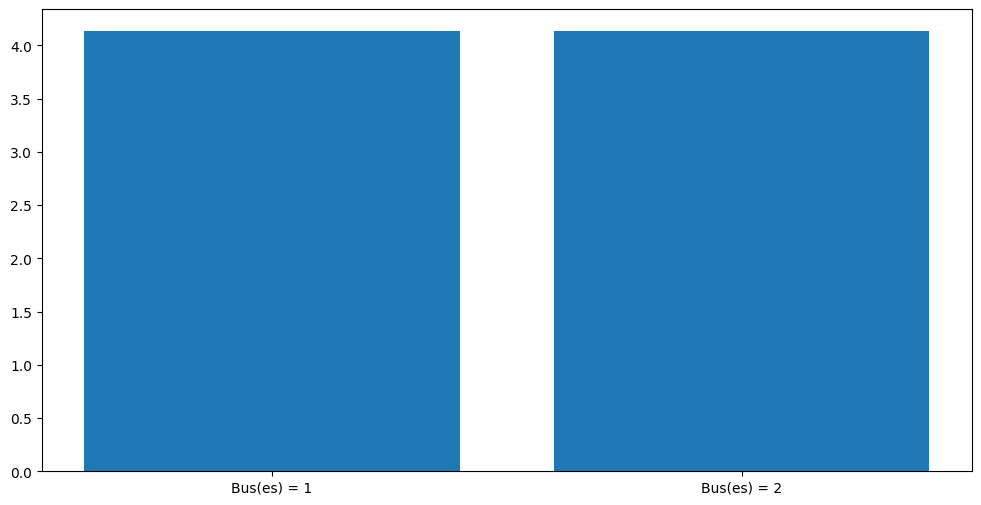

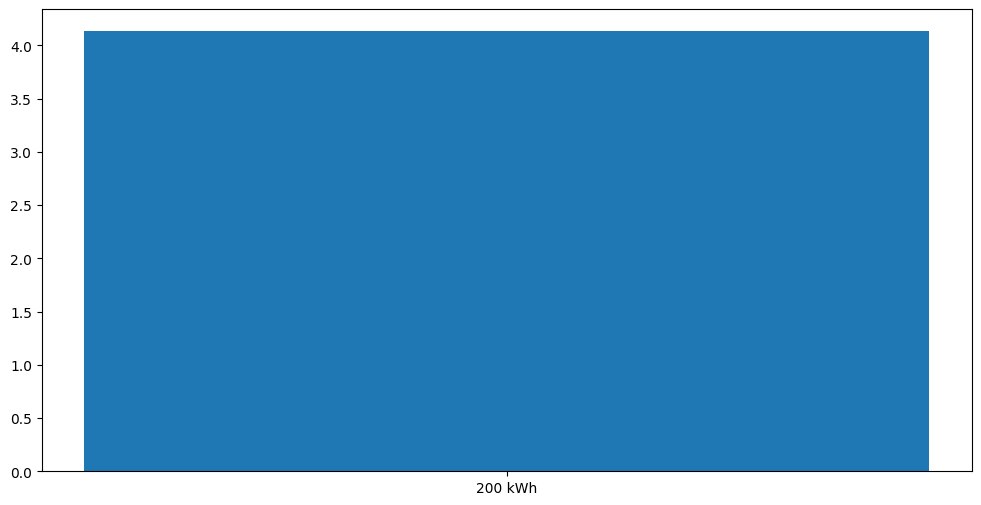

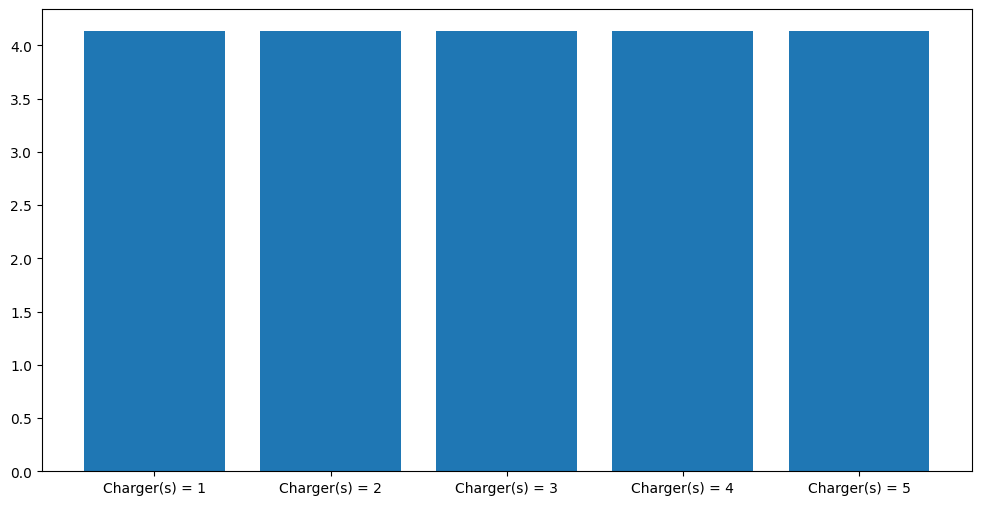

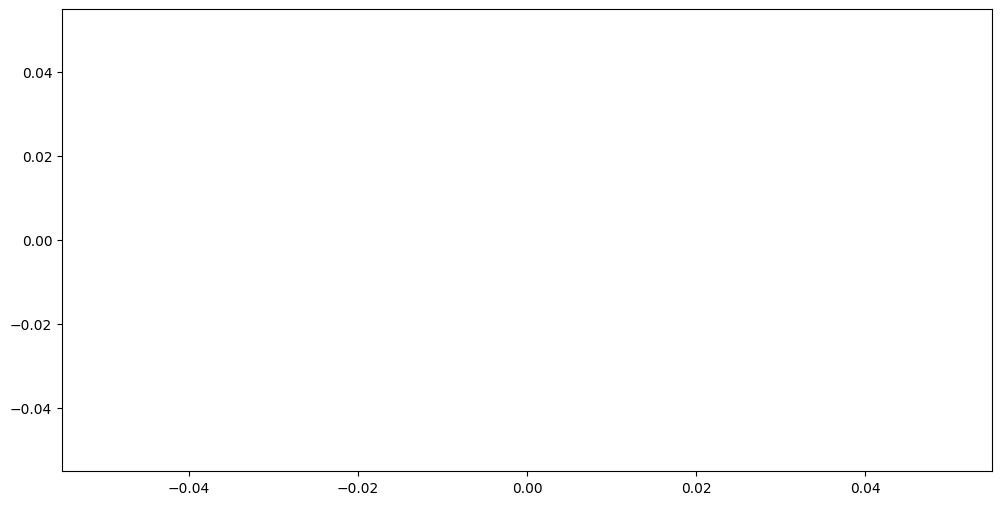

In [24]:
# Defining the values for the sensitivity analysis

num_bus = 10 # max. number of buses to iterate
battery = [100,350,25] # begin, end, step
num_char = 10 # max. number of chargers to iterate
power = [50,450,50]
scale_factor = 60
power = [float(i) / scale_factor for i in power]

model_bus, model_bat, model_char, model_pow, result_bus, result_bat, result_char, result_pow = run_sensitivity(num_bus,battery,num_char,power)

## Visualization

In [25]:
Energy, Power, Degradation = visualizationData(model_bus.K,model_bus.T,model_bus.e,model_bus.w_sell,model_bus.d)

,bus 1,bus 2
count,1.440000e+03,1440.000000
mean,6.960000e+01,123.429247
std,1.336284e-12,52.037510
min,6.960000e+01,69.600000
25%,6.960000e+01,70.009926
50%,6.960000e+01,114.621022
75%,6.960000e+01,170.522579
max,6.960000e+01,208.800000


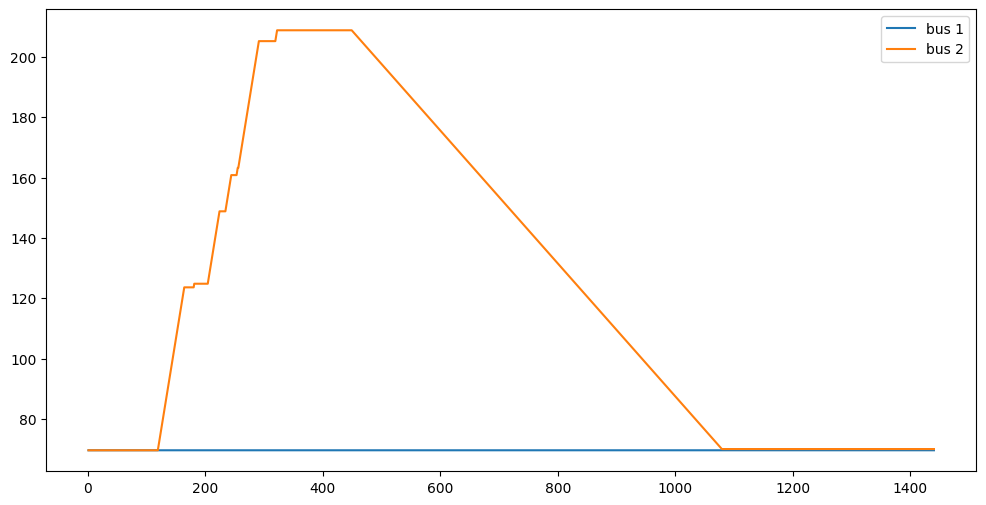

In [26]:
Energy.plot(figsize=(12,6))
Energy.describe()